In [2]:
import numpy as np
import cPickle
import math
import sys
import emcee
import scipy.optimize as op
import matplotlib.pyplot as plt
import corner
%matplotlib inline

In [3]:
def pickle_to_file(data, fname):
    """Save a variable simply to a file"""
    try:
        fh = open(fname, 'w')
        cPickle.dump(data, fh)
        fh.close()
    except:
        print "Pickling failed!", sys.exc_info()[0]

def pickle_from_file(fname):
    """Restore a variable saved with pickle_to_file"""
    try:
        fh = open(fname, 'r')
        data = cPickle.load(fh)
        fh.close()
    except:
        print "Loading pickled data failed!", sys.exc_info()[0]
        data = None

    return data

In [4]:
#Dictionary
d = pickle_from_file('data-for-poly-test.pkl')
print d

{'y': array([ 0.82335125,  1.5143732 , -0.21704837,  0.33184369,  0.0786035 ,
        0.02511367,  0.0466854 ,  0.63996613,  0.74664642,  1.10185182,
        0.80585326,  1.43927215,  0.18360144,  2.09060301, -0.17936281,
        1.51248316,  0.64156174,  1.07092463, -0.00727646,  0.09761826]), 'x': array([  7.08937408e-01,   1.22455164e+00,   1.94437189e-04,
         5.13965373e-01,   2.49485014e-01,   1.56975611e-01,
         3.16642359e-01,   5.87453236e-01,   6.74504706e-01,
         9.15988448e-01,   7.12630674e-01,   1.16487315e+00,
         3.47568825e-01,   1.49279964e+00,   4.65589084e-02,
         1.13979477e+00,   7.09418164e-01,   9.49772708e-01,
         2.38657796e-01,   3.36772531e-01]), 'sigma_y': array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])}


<Container object of 3 artists>

/Users/guadalupecanasherrera/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


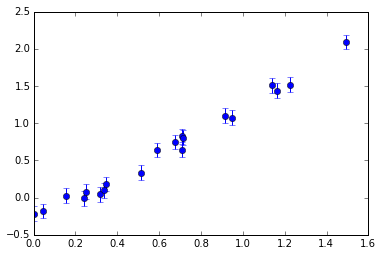

In [5]:
#Ploteo los datos 
plt.errorbar(d['x'], d['y'], yerr=d['sigma_y'], fmt='o')

{'1': array([-0.32719384,  1.54478251]), '2': array([-0.25578924,  1.22632493,  0.22789355])}


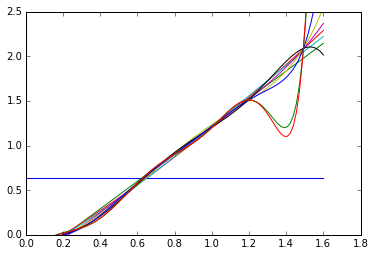

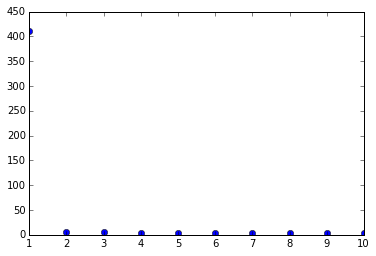

In [94]:
#Exercise (a) and (b): Define the maximum likelihood (ML)
def neglnL(theta, x, y, yerr):
    model = np.polynomial.polynomial.polyval(x, theta)
    
    #print "model is= {0}".format(model)
    
    inv_sigma2 = 1.0/(yerr**2)
    return 0.5*(np.sum((y-model)**2*inv_sigma2))

def lnL(theta, x, y, yerr):
    model = np.polynomial.polynomial.polyval(x, theta)
    
    #print "model is= {0}".format(model)
    
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

n=9
array_ml = []
maximum_like_per_n = []
nums=[]

thetas_init = {'1':0, '2':0}

plt.figure()
for i in range (1, n+2):
    thetas_op=[]  
    theta = np.random.randn(i) 
    
    
    result_all = op.minimize(neglnL, theta, args = ( d['x'], d['y'], d['sigma_y']))
    array_ml.append(result_all)  
    thetas_op = result_all["x"]    
    
    #print "Thetas is= {0}".format(thetas_op)
    
    maximum_like_per_n.append(neglnL(thetas_op, d['x'], d['y'], d['sigma_y']))    
    nums.append(i)
    y_fit = np.polynomial.polynomial.polyval(np.linspace(0, 1.6, num=100), thetas_op)
    
    #print "Y_model is= {0}".format(np.polynomial.polynomial.polyval(d['x'], thetas_op))
    #print theta
    
    plt.plot(np.linspace(0, 1.6, num=100), y_fit, '-')
    
    y_fit =0
    
    plt.ylim(0, 2.5)
    
    if i == 2:
        thetas_init['1']=thetas_op
    if i == 3:
        thetas_init['2']=thetas_op
    

print thetas_init
plt.figure()
plt.plot(nums, maximum_like_per_n, 'o')


#Conclusion: no, the likelihood of the best-fitting model does not provide a  good wat to decide which model is the best.
#You cannot distinguish between n=1, 2, 3, 4, 5...

823.77250044
822.776768166


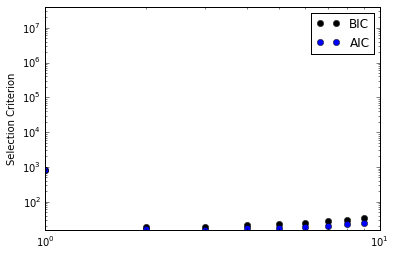

In [82]:
#Exercise (c): programming  BIC and AIC for all n
BIC = []
AIC = []
size = len(d['x'])

for i in range (1, n+1):
    bic = 2.0*(maximum_like_per_n[i-1])+i*np.log(size)
    BIC.append(bic)
    aic = 2.0*(maximum_like_per_n[i-1])+2*i
    AIC.append(aic)

plt.figure()
plt.loglog(nums, BIC, 'ko', label="BIC")
plt.loglog(nums, AIC, 'bo', label="AIC")
#plt.xlabel("order of polinomia")
plt.ylabel("Selection Criterion")
plt.ylim(0, 0.4E8)
plt.legend()

print BIC[0]
print AIC[0]


[[-0.27681888  1.52012125]
 [-0.27681888  1.52012125]
 [-0.27681888  1.52012125]
 ..., 
 [-0.34352527  1.57476816]
 [-0.34716408  1.57695935]
 [-0.34716408  1.57695935]]


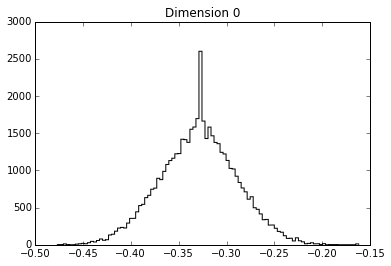

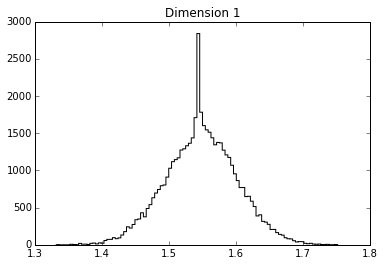

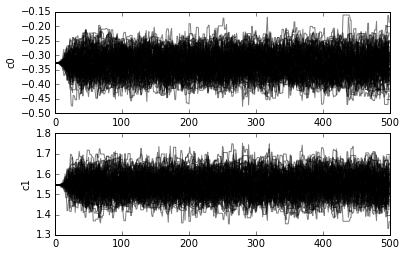

In [106]:
# Exercise (d): comparing models usings bayesian statistics. Need to calculate a prior and running emcee

limits_for_prior = 100.0

def lnprior(theta):
    for elements in theta:
        if -limits_for_prior < elements < limits_for_prior:
            #return np.log(limits_for_prior**-len(theta)) #PREGUNTAR !!!!!!!!
            return np.log(200)
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)    
    if not np.isfinite(lp):
        return -np.inf
    return lp+lnL(theta, x, y, yerr)


#MCMC for n=1
# Set up the properties of the problem.
ndim1, nwalkers1 = 2, 100
# Setup a number of initial positions.
pos1 = [thetas_init['1'] + 1e-4*np.random.randn(ndim1) for i in range(nwalkers1)]
# Create the sampler.
sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, lnprob, args=(d['x'], d['y'], d['sigma_y']))
# Run the process.
pos1, prob1, state1 = sampler1.run_mcmc(pos1, 500)
#plot histogram
for i in range(ndim1):
    plt.figure()
    plt.hist(sampler1.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))
#Let's plots the chains
labels = ['c0', 'c1']
chain = sampler1.chain
plt.figure()
for i_dim in range(ndim1):
    plt.subplot(2, 1, i_dim+1)
    plt.ylabel(labels[i_dim])
    for i in range(100):
        plt.plot(chain[i, :, i_dim], color='black', alpha=0.5)

nburn1=100        
trace1 = sampler1.chain[:, nburn1:, :].reshape(-1, ndim1)
lnprob1 = sampler1.lnprobability[:,nburn1:].reshape(-1, 1)

print trace1


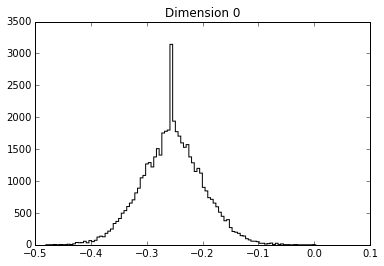

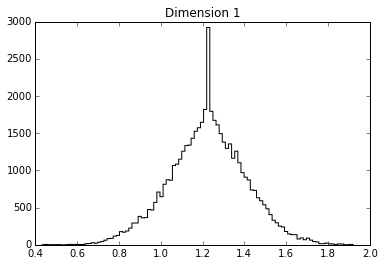

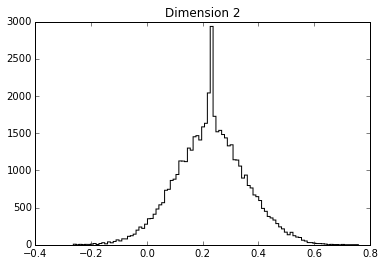

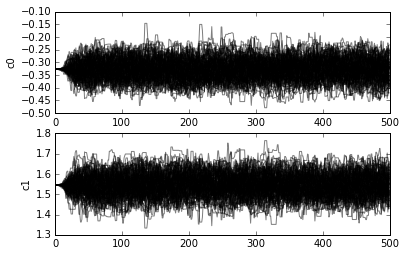

In [104]:
#MCMC for n=2
# Set up the properties of the problem.
ndim2, nwalkers2 = 3, 100
# Setup a number of initial positions.
pos2 = [thetas_init['2'] + 1e-4*np.random.randn(ndim2) for i in range(nwalkers2)]
# Create the sampler.
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, lnprob, args=(d['x'], d['y'], d['sigma_y']))
# Run the process.
pos2, prob2, state2 = sampler2.run_mcmc(pos2, 500)
#plot histogram
for i in range(ndim2):
    plt.figure()
    plt.hist(sampler2.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))
    
plt.figure()
for i_dim in range(ndim1):
    plt.subplot(2, 1, i_dim+1)
    plt.ylabel(labels[i_dim])
    for i in range(100):
        plt.plot(chain[i, :, i_dim], color='black', alpha=0.5)